# __AR(I)MA__

#### __Autoregression _AR(p)___

$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \phi_{p}y_{t-p} + \varepsilon_{t}$ <br/>
<br/>
$c$: constant

#### __Differencing _I(d)___

$y_{t}´ = y_t - y_{t-1}$ <br/>
<br/>
$y_{t}´´ = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$

#### __Moving average model _MA(q)___

$y_{t} = c + \varepsilon_{t} + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \theta_{q}\varepsilon_{t-q}$ <br/>
<br/>
$c$: mean

#### __ARIMA(p,d,q)__

$y´_{t} = c + \phi_{1}y´_{t-1} + ... + \phi_{p}y´_{t-p} + \theta_{1}\varepsilon_{t-1} + ... + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

In [12]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima # on order to determine ARIMA orders

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
df1 = pd.read_csv('../data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv('../data/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

## __Augmented Dickey-Fuller Test__
The Augmented Dickey-Fuller Test cheks for stationarity of a time series. Note that ARIMA can only be performed on stationary datasets. It might be possible that more than a one-time differencing is necessary.

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() since differencing produces NaNs
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## __ARMA__

ARMA is just a special case of ARIMA, namely when forecasting stationary data not requiring any differencing.

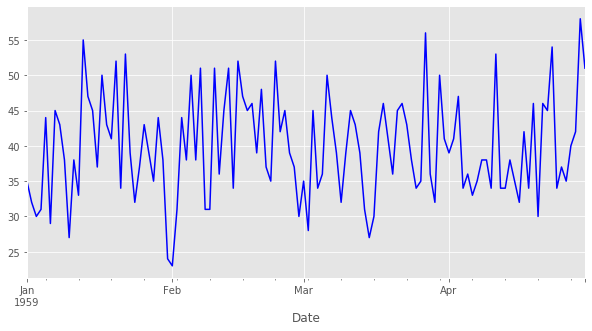

In [14]:
plt.style.use('ggplot')

df1['Births'].plot(figsize=(10,5), color='blue');

### __Dickey-Fuller Test to check for stationarity__

$H_0$: Time series IS NOT stationary (if p-value > 0.05)

$H_1$: Time series IS stationary (if p-value <= 0.05)

In [10]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### __Determine the (p,q) ARMA orders using pmdarima.auto_arima__
This tool provides best recommendations for p and q analogous to Grid Search in scikit-learn.

__Usage of Akaike Information Criterion (AIC)__

AIC valuates collection of models and estimates quality of each model __relative__ to the others. __Penalties__ are are provided^for the number of parameters used in an effort to thwart overfitting.

A good model is the one that has minimum AIC among all the other models. 

In [15]:
auto_arima(df1['Births'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 2)   Log Likelihood                -405.370
Method:                       css-mle   S.D. of innovations              6.991
Date:                Tue, 19 Nov 2019   AIC                            822.741
Time:                        12:16:37   BIC                            839.466
Sample:                             0   HQIC                           829.533
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8162      0.108    368.745      0.000      39.605      40.028
ar.L1.y        1.8568      0.081     22.915      0.000       1.698       2.016
ar.L2.y       -0.8813      0.073    -12.020      0.000      -1.025      -0.738
ma.L1.y       -1.8633      0.109    -17.117      0.000      -2.077      -1.650
ma.L2.y        0.8633      0.108      8.015      0.000       0.652       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0534           -0.1582j            1.0652           -0.0237
AR.2            1.0534           +0.1582j            1.0652            0.0237
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1584           +0.0000j            1.1584            0.0000
-----------------------------------------------------------------------------
"""

### __Test / train split__
Rule of thumb: set the length of your test set equal to your intended forecast size. Here: 1 month

In [16]:
train = df1.iloc[:90]
test = df1.iloc[90:]

### __Fit ARMA(p,q) Model__
Also check out help(ARMA) to learn what incoming arguments are available/expected, and what's being returned.

In [17]:
model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Tue, 19 Nov 2019   AIC                            627.809
Time:                        12:44:53   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7433           +0.0000j            1.7433            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

This suggests we should use an ARMA(2,2) to fit our data.

### __Predicted values for single month__

In [18]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

### __Plot predictions vs actuals__

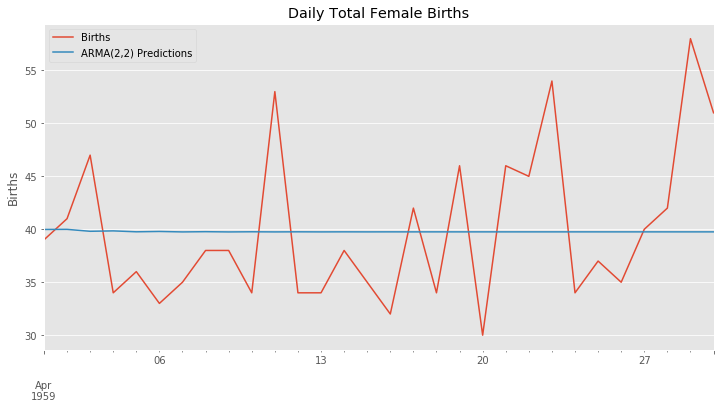

In [19]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense.

## __ARIMA__

Now we will use an non-stationary dataset, hence it requires differencing (_I_).

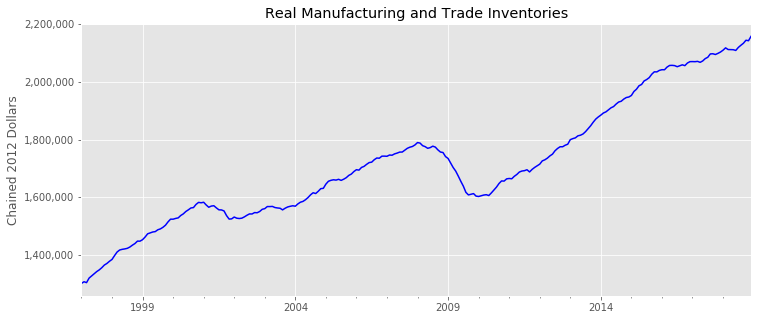

In [22]:
import matplotlib.ticker as ticker #adding ticks to y-values
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title, color='blue')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### __Run seasonal_decompose to check for potential seasonality__

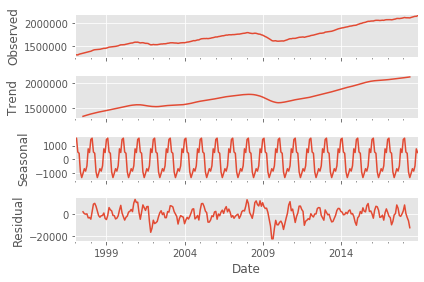

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

The decomposition detects a seasonal component. However, its magnitude suggests only a minor effect. We hence treat our dataset as a non-seasonal one.

In [28]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Tue, 19 Nov 2019   AIC                           5228.505
Time:                        12:57:15   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3468.4548   1313.324      2.641      0.009     894.386    6042.523
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.546      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

This suggests we should use an ARIMA(1,1,1) to fit our data.

### __Let's check all this manually (demonstration purpose only)__

In [29]:
#Let's difference once as suggested by auto_arima and see what the adf_test tells us
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This suggests that we reached stationarity after the first difference as expected from auto_arima.
### Run the ACF and PACF plots
A PACF Plot can reveal recommended AR(p) orders, and an ACF Plot can do the same for MA(q) orders.

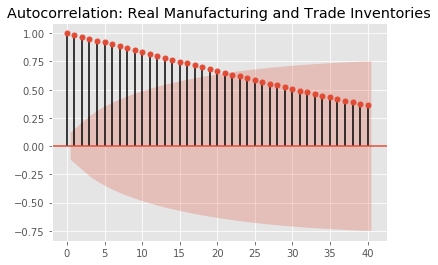

In [31]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

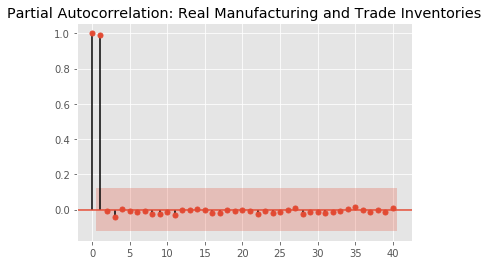

In [32]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [33]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.070 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.812, Fit time=0.049 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.126 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.527, BIC=5247.387, Fit time=0.144 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.168 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.290, BIC=5247.150, Fit time=0.201 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.799 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Tue, 19 Nov 2019   AIC                           5228.505
Time:                        13:06:18   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3468.4548   1313.324      2.641      0.009     894.386    6042.523
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.546      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.7446           +0.0000j            1.7446            0.0000
-----------------------------------------------------------------------------
"""

Our manual checkup on the p,d,q parameters confirmed our outcome of the initial auto_arima.

### __train /test split__

In [34]:
len(df2)

264

In [35]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

### __Fit on ARIMA(1,1,1) model__

In [36]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.394
Method:                       css-mle   S.D. of innovations           4845.007
Date:                Tue, 19 Nov 2019   AIC                           4980.788
Time:                        13:09:08   BIC                           4994.890
Sample:                    02-01-1997   HQIC                          4986.463
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3235.7979   1344.940      2.406      0.017     599.764    5871.832
ar.L1.D.Inventories     0.9026      0.039     23.012      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7917           +0.0000j            1.7917            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [38]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2107156.741, expected=2110158
predicted=2110545.923, expected=2118199
predicted=2113920.16 , expected=2112427
predicted=2117280.909, expected=2112276
predicted=2120629.483, expected=2111835
predicted=2123967.068, expected=2109298
predicted=2127294.736, expected=2119618
predicted=2130613.453, expected=2127170
predicted=2133924.091, expected=2134172
predicted=2137227.436, expected=2144639
predicted=2140524.201, expected=2143001
predicted=2143815.024, expected=2158115


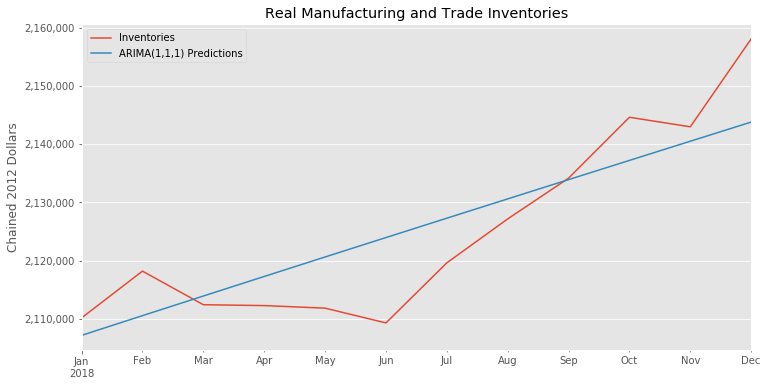

In [40]:
# Plot predictions vs actuals
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### __Model evaluation__

In [41]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 60315541.59


In [42]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 7766.308105


In [45]:
relative_error = error / predictions.mean()
relative_error

0.003653744676821155

### __Apply model to complete dataset__

In [46]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

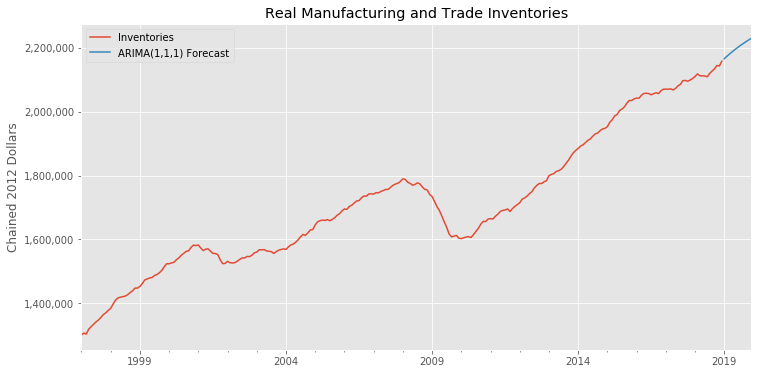

In [47]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## Great job!